# Neural Network Compression with the Tensor-Train Decomposition in ``TensorLy`` and ``PyTorch``

In this notebook, we will show how to use **TensorLy** [1] to store the weights of a deep neural network (DNN) in the Tensor-Train (TT) format [2].

As a toy example, we show how one can use 1/4 of the number of parameters for a network to classify digits in the MNIST dataset, whilst sacrificing only a 2% drop in classification over its counterpart in non TT-format.

Included is the following:

1. [Storing an FC layer's weights in the TT-format](#Storing-an-FC-layer's-weights-in-the-TT-format)
2. [Defining the networks](#Define-the-networks)
3. [Model comparison (number of parameters vs accuracy)](#Model-comparison)

---

[1]: Jean Kossaifi, Yannis Panagakis, Anima Anandkumar and Maja Pantic, TensorLy: Tensor Learning in Python, https://arxiv.org/abs/1610.09555.

[2]: A. Novikov, D. Podoprikhin, A. Osokin, and D. Vetrov, ‘Tensorizing Neural Networks’, arXiv:1509.06569 [cs], Dec. 2015, Accessed: Jul. 27, 2020. [Online]. Available: http://arxiv.org/abs/1509.06569.

In [14]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F

import numpy as np

import tensorly as tl
from tensorly.random import check_random_state

Import TensorLy and set the backend to PyTorch:

In [15]:
import tensorly as tl
tl.set_backend('pytorch')

Parameters of the experiment:

In [16]:
batch_size = 16
device = 'cpu'

Let us load the MNIST dataset. The following code will automatically download the data in a `data` folder if it hasn't already been done.

In [4]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Resize((32, 32)),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/', train=False, transform=transforms.Compose([
                       transforms.Resize((32, 32)),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

## Storing an FC layer's weights in the TT-format

One option is to apply the TT-decomposition directly on the weight matrices $\mathbf{W}$. This simply corresponds to the standard matrix decomposition however, and thus doesn't fully exploit the parameter-saving capabilities of the TT-decomposition.

Given the weights $\mathbf{W}$ of a fully-connected layer, we first reshape the matrix into a higher-order tensor $\mathcal{W}$. We can then represent $\mathcal{W}$ in the TT-format--greatly reducing the number of parameters we have to store, with us only needing to store the TT-cores.

In [21]:
def get_dimensions(rows, cols):
    # form the dims of the tensor W: # kth dimension is formed by i_k*j_k
    return [I_k*J_k for I_k, J_k in zip(rows, cols)]

class TTLayer(nn.Module):
    """
    Stores the weights of a fully connected layer in the TT-format
    """
    def __init__(self, matrix_shape, cols, rows, rank=8, **kwargs):
        super(TTLayer, self).__init__(**kwargs)
        
        assert(matrix_shape[0]==np.prod(cols))
        assert(matrix_shape[1]==np.prod(rows))
        
        self.rank = rank
        self.matrix_shape = matrix_shape
        
        # get the dimensions of the len(rows)-order tensor
        self.dimensions = get_dimensions(rows, cols)
        
        # Add and register the factors
        self.factors = nn.ParameterList(
            [nn.Parameter(f, requires_grad=True) for f in tl.random.random_mps(self.dimensions, rank)]
        )
        
        for f in self.factors:
            f.data.uniform_(-0.1, 0.1)
            
    def forward(self, x):
        # form full tensor
        W = tl.mps_to_tensor(self.factors)
        W = tl.reshape(W, self.matrix_shape)
        
        return torch.matmul(W, x)
    
    def get_num_params(self):
        return sum([p.numel() for p in self.parameters()])

# Define the networks

We'll define a very simple fully-connected network with two layers, following the experiments section in [2]. The network is thus composed of two weight matrices: $\mathbf{W}^{(1)}\in\mathbb{R}^{1024\times1024}$ and $\mathbf{W}^{(2)}\in\mathbb{R}^{10\times1024}$.

![simple architecture](./images/fc-tt.png)

We'll store these weights explicitly in the first model, and then we'll also store them in the TT-format in the second two models, and see how the networks perform.

In [22]:
class Net(nn.Module):
    def __init__(self, use_tt=False, rank=32):
        super(Net, self).__init__()

        # w1 (1024 x 1024)
        # desired TT-shapes for width and height of matrix
        w1_cols = [4, 4, 4, 4, 4]
        w1_rows = [4, 4, 4, 4, 4]

        # w2 (10 x 1024)
        w2_cols = [5, 2, 1, 1, 1]
        w2_rows = [4, 4, 4, 4, 4]
        
        self.fc1 = TTLayer((1024, 1024), w1_cols, w1_rows, rank=rank) if use_tt else nn.Linear(1024, 1024)
        self.fc2 = TTLayer((10, 1024), w2_cols, w2_rows, rank=rank) if use_tt else nn.Linear(1024, 10)
        
    def get_num_params(self):
        return sum([p.numel() for p in self.parameters() if p.requires_grad])

    def forward(self, x):
        x = torch.nn.Flatten()(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)
    
ranks = [64, 32]
models = [
    Net(use_tt=False),
    Net(use_tt=True, rank=ranks[0]),
    Net(use_tt=True, rank=ranks[1]),
]

Finally, the training loop.

In [7]:
import time

n_epoch = 5 # Number of epochs

models_acc = []
for i, model in enumerate(models):
    model = model.to(device)
    print('Training network {}...'.format(i))
    start = time.process_time()

    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion=nn.CrossEntropyLoss()

    def train(n_epoch):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            # Important: do not forget to reset the gradients
            optimizer.zero_grad()

            output = model(data)
            loss = criterion(output,target)
            loss.backward()
            optimizer.step()

    def test():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss = criterion(output,target)
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        test_loss /= len(test_loader.dataset)
        
        return 100. * correct / len(test_loader.dataset)

    for epoch in range(1, n_epoch):
        train(epoch)
        acc = test()
        
    print('Test set acc: {}%\tTime taken: {}'.format(acc, time.process_time() - start))
    models_acc += [acc]

Training network 0...
Test set acc: 97.9000015258789%	Time taken: 436.562253482
Training network 1...
Test set acc: 96.02999877929688%	Time taken: 2090.609674247
Training network 2...
Test set acc: 95.02999877929688%	Time taken: 1030.9063246240003


## Model comparison

Plotted below is the models' number of parameters and their respective test-set accuracies after 5 epochs of training.

As we can see, storing the weights in the TT-format allows us to store the model with very few paramters: even as few as 1/25 the number of parameters of the original network!

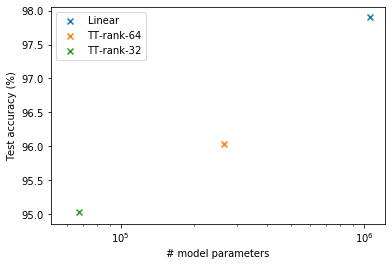

In [9]:
from matplotlib import pyplot as plt

xs = ['Linear'] + ['TT-rank-{}'.format(rank) for rank in ranks]
for i, x in enumerate(xs):
    plt.scatter(models[i].get_num_params(), models_acc[i], label=x, marker='x')
    plt.legend()

plt.xscale('log')
plt.xlabel('# model parameters')
plt.ylabel('Test accuracy (%)')
plt.show()